<a href="https://colab.research.google.com/github/LibbyChristian/data-driven-dream/blob/main/Tanzania_Electrification_Strategy_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting Tanzania Regional Strategy Analysis...

--- Analysis Complete ---
Segmentation chart saved to: results/strategic_segmentation_chart.png

Top 5 Regions by Strategic Demand Score (Full Data):
          Region  Strategic_Demand_Score  Household_Electrification_Rate  \
0  Dar es Salaam                0.795876                        0.950000   
2         Arusha                0.627819                        0.638166   
3          Mbeya                0.441093                        0.192309   
1         Mwanza                0.376866                        0.750000   
4         Dodoma                0.268443                        0.691499   

   Infra_Gap_Score                        Strategic_Segment  
0         0.050000      2. High-Demand Saturated (Maintain)  
2         0.361834      2. High-Demand Saturated (Maintain)  
3         0.807691  1. High-Potential Gap (Target Priority)  
1         0.250000      2. High-Demand Saturated (Maintain)  
4         0.308501      2. High-De

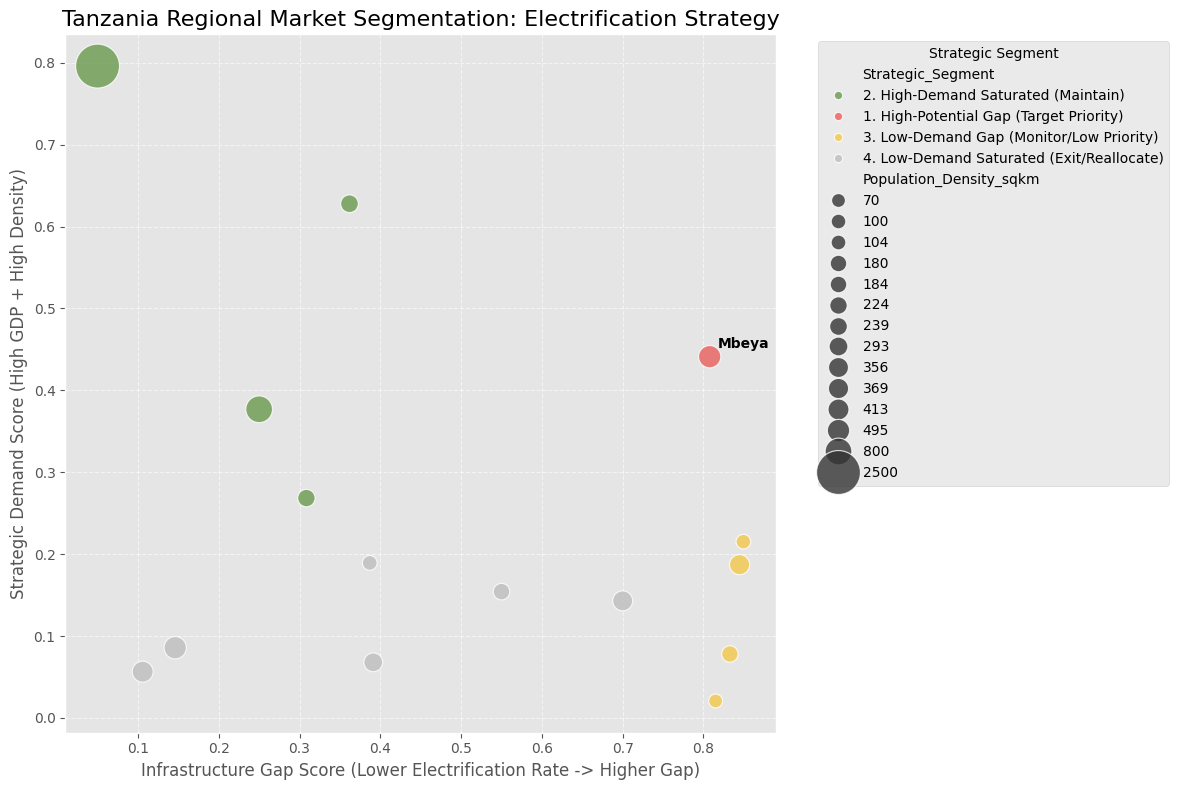

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os # Import the os module

# --- PROJECT CONSTANTS ---
# Siimulated data that mimics regional
# socio-economic and infrastructure indicators in Tanzania.

def load_simulated_data():
    """
    Loads simulated regional data for analysis.
    Data is based on known regional distributions in Tanzania.
    """
    np.random.seed(42)
    regions = [
        "Dar es Salaam", "Mwanza", "Arusha", "Mbeya", "Dodoma",
        "Kigoma", "Tabora", "Ruvuma", "Mtwara", "Singida",
        "Tanga", "Morogoro", "Lindi", "Pwani", "Rukwa"
    ]
    n = len(regions)

    # Simulated Data Columns
    data = {
        'Region': regions,
        # Proxy for Economic Activity (Strategic Demand Indicator)
        'GDP_per_Capita_USD': np.random.randint(500, 1500, n) + np.array([1000, 1200, 1100, 950, 700] + [0]*(n-5)),
        # Proxy for Infrastructure Gap (Operational Challenge Indicator)
        'Household_Electrification_Rate': np.random.uniform(0.15, 0.90, n),
        # Proxy for Market Size
        'Population_Density_sqkm': np.random.randint(50, 500, n),
        # Proxy for Potential Business Opportunity
        'Avg_Household_Size': np.random.uniform(4.0, 7.0, n),
    }

    df = pd.DataFrame(data)

    df.loc[df['Region'] == 'Dar es Salaam', ['GDP_per_Capita_USD', 'Household_Electrification_Rate', 'Population_Density_sqkm']] = [1800, 0.95, 2500]
    df.loc[df['Region'] == 'Mwanza', ['GDP_per_Capita_USD', 'Household_Electrification_Rate', 'Population_Density_sqkm']] = [1350, 0.75, 800]
    df.loc[df['Region'] == 'Lindi', 'Household_Electrification_Rate'] = 0.30
    df.loc[df['Region'] == 'Pwani', 'Household_Electrification_Rate'] = 0.45

    return df

def feature_engineering(df):
    """
    Creates strategic scores for segmentation.
    1. Demand Score: High economic activity and high population density.
    2. Infrastructure Gap Score: Low electrification rate.
    """
    # Normalize data for scoring (0 to 1)
    for col in ['GDP_per_Capita_USD', 'Population_Density_sqkm']:
        min_val = df[col].min()
        max_val = df[col].max()
        df[f'{col}_Norm'] = (df[col] - min_val) / (max_val - min_val)

    # 1. Strategic Demand Score (Weighted average of economic activity and density)
    df['Strategic_Demand_Score'] = (
        0.6 * df['GDP_per_Capita_USD_Norm'] +
        0.4 * df['Population_Density_sqkm_Norm']
    )

    # 2. Infrastructure Gap Score (Lower electrification rate means higher gap)
    df['Infra_Gap_Score'] = 1 - df['Household_Electrification_Rate']

    return df.sort_values(by='Strategic_Demand_Score', ascending=False)

def create_strategic_segmentation(df):
    """
    Segments regions based on Strategic Demand and Infrastructure Gap.
    """
    # Define thresholds (based on tertiles or quartiles, here simplified for example)
    demand_threshold = df['Strategic_Demand_Score'].quantile(0.66)
    gap_threshold = df['Infra_Gap_Score'].quantile(0.66)

    def segment_region(row):
        if row['Strategic_Demand_Score'] >= demand_threshold and row['Infra_Gap_Score'] >= gap_threshold:
            return '1. High-Potential Gap (Target Priority)'
        elif row['Strategic_Demand_Score'] >= demand_threshold:
            return '2. High-Demand Saturated (Maintain)'
        elif row['Infra_Gap_Score'] >= gap_threshold:
            return '3. Low-Demand Gap (Monitor/Low Priority)'
        else:
            return '4. Low-Demand Saturated (Exit/Reallocate)'

    df['Strategic_Segment'] = df.apply(segment_region, axis=1)
    return df

def plot_segmentation(df):
    """
    Generates a scatter plot for visual strategic segmentation.
    """
    plt.style.use('ggplot')
    plt.figure(figsize=(12, 8))

    # Define colors for segments
    segment_colors = {
        '1. High-Potential Gap (Target Priority)': '#E85F5C', # Red for urgency/opportunity
        '2. High-Demand Saturated (Maintain)': '#6A994E',    # Green for established success
        '3. Low-Demand Gap (Monitor/Low Priority)': '#F2C94C', # Yellow for watch list
        '4. Low-Demand Saturated (Exit/Reallocate)': '#BDBDBD'  # Gray for low priority
    }

    sns.scatterplot(
        x='Infra_Gap_Score',
        y='Strategic_Demand_Score',
        data=df,
        hue='Strategic_Segment',
        palette=segment_colors,
        size='Population_Density_sqkm',
        sizes=(100, 1000),
        alpha=0.8,
        legend='full'
    )

    # Add labels for the target priority regions
    target_regions = df[df['Strategic_Segment'] == '1. High-Potential Gap (Target Priority)']
    for i, row in target_regions.iterrows():
        plt.text(row['Infra_Gap_Score'] + 0.01, row['Strategic_Demand_Score'] + 0.01,
                 row['Region'], fontsize=10, ha='left', weight='bold')

    plt.title('Tanzania Regional Market Segmentation: Electrification Strategy', fontsize=16)
    plt.xlabel('Infrastructure Gap Score (Lower Electrification Rate -> Higher Gap)', fontsize=12)
    plt.ylabel('Strategic Demand Score (High GDP + High Density)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='Strategic Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Save the plot
    plot_filepath = 'results/strategic_segmentation_chart.png'
    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(plot_filepath), exist_ok=True)
    plt.savefig(plot_filepath)
    print(f"\n--- Analysis Complete ---")
    print(f"Segmentation chart saved to: {plot_filepath}")

    # Display key data for the README
    print("\nTop 5 Regions by Strategic Demand Score (Full Data):")
    print(df[['Region', 'Strategic_Demand_Score', 'Household_Electrification_Rate', 'Infra_Gap_Score', 'Strategic_Segment']].head())
    return df

if __name__ == "__main__":
    print("Starting Tanzania Regional Strategy Analysis...")

    # 1. Load Data
    data_df = load_simulated_data()

    # 2. Feature Engineering & Scoring
    scored_df = feature_engineering(data_df)

    # 3. Strategic Segmentation
    segmented_df = create_strategic_segmentation(scored_df)

    # 4. Visualization and Output
    plot_segmentation(segmented_df)

    print("\nReview the README.md for Strategic Recommendations based on this analysis.")